In [1]:
import sys

sys.path.append("C:/Users/junsu/volatility_arbitrage")

In [2]:
from volatility_arbitrage.pricing_model.interface import Correlation, HestonParams
from volatility_arbitrage.pricing_model.heston_model import generate_inefficient_market
from volatility_arbitrage.pricing_model.weighted_variance_swap import (
    VarianceSwap,
    StrategyPnlCalculator,
)
from volatility_arbitrage.strategy.evaluation import (
    plot_pnl_of_path,
    plot_vega_hedge_performance_of_path,
    plot_pnl_distribution,
)
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

In [3]:
BDAYS = 252

length = BDAYS
time_delta = 1 / length
implied_vol = 0.2
realized_vol = 0.16
num_path = 10_000

corr = Correlation(-0.754, -0.4, 0.6)
imp_var_params = HestonParams(kappa=5, mean_of_var=implied_vol**2, vol_of_var=0.5)
real_var_params = HestonParams(kappa=5, mean_of_var=realized_vol**2, vol_of_var=0.5)

np.random.seed(0)
lr, real_var, imp_var = generate_inefficient_market(
    real_var_0=realized_vol**2,
    imp_var_0=implied_vol**2,
    real_var_params=real_var_params,
    imp_var_params=imp_var_params,
    corr=corr,
    num_path=num_path,
    length=length,
    time_delta=time_delta,
)

f = 100 * np.exp(np.cumsum(lr, axis=0))

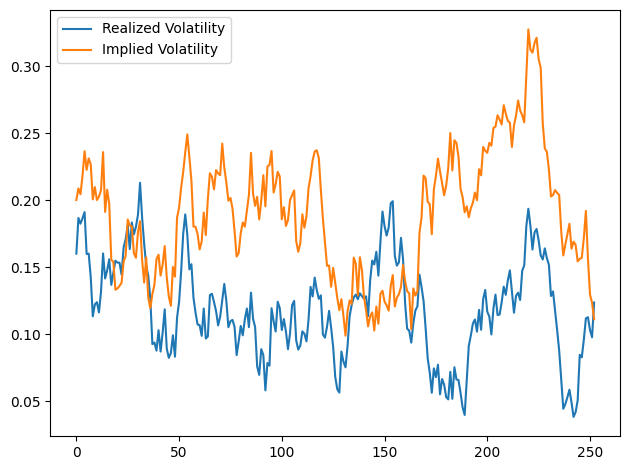

In [4]:
fig, ax = plt.subplots()
ax.plot(np.sqrt(real_var[:, 0]), label="Realized Volatility")
ax.plot(np.sqrt(imp_var[:, 0]), label="Implied Volatility")
ax.legend()
fig.tight_layout()
plt.show()

# Trading Variance Swap Rolling Everyday

In [5]:
target_dte = np.arange(1, BDAYS + 1, 1)

variance_swap = VarianceSwap(
    imp_var_params=imp_var_params, real_var_params=real_var_params, corr=corr
)
var_swap_pnl_per_dte: dict[int, StrategyPnlCalculator] = {}

for dte in target_dte:
    tau_0 = np.full_like(imp_var[1:], dte / BDAYS)
    tau_1 = np.full_like(imp_var[1:], dte / BDAYS - time_delta)

    pnl_calculator = variance_swap.get_pnl_calculator(
        f_0=f[:-1],
        f_t=f[1:],
        real_var_0=real_var[:-1],
        imp_var_0=imp_var[:-1],
        tau_0=tau_0,
        imp_var_t=imp_var[1:],
        tau_t=tau_1,
    )
    var_swap_pnl_per_dte[dte] = pnl_calculator

## Trading 1 Month Variance Swap

### Continuous Short Variance Swap Strategy

In [6]:
cont_short_strategy = -np.ones_like(real_var[:-1]) * 100
cont_short_pnl = var_swap_pnl_per_dte[21].get_strategy_pnl(cont_short_strategy)

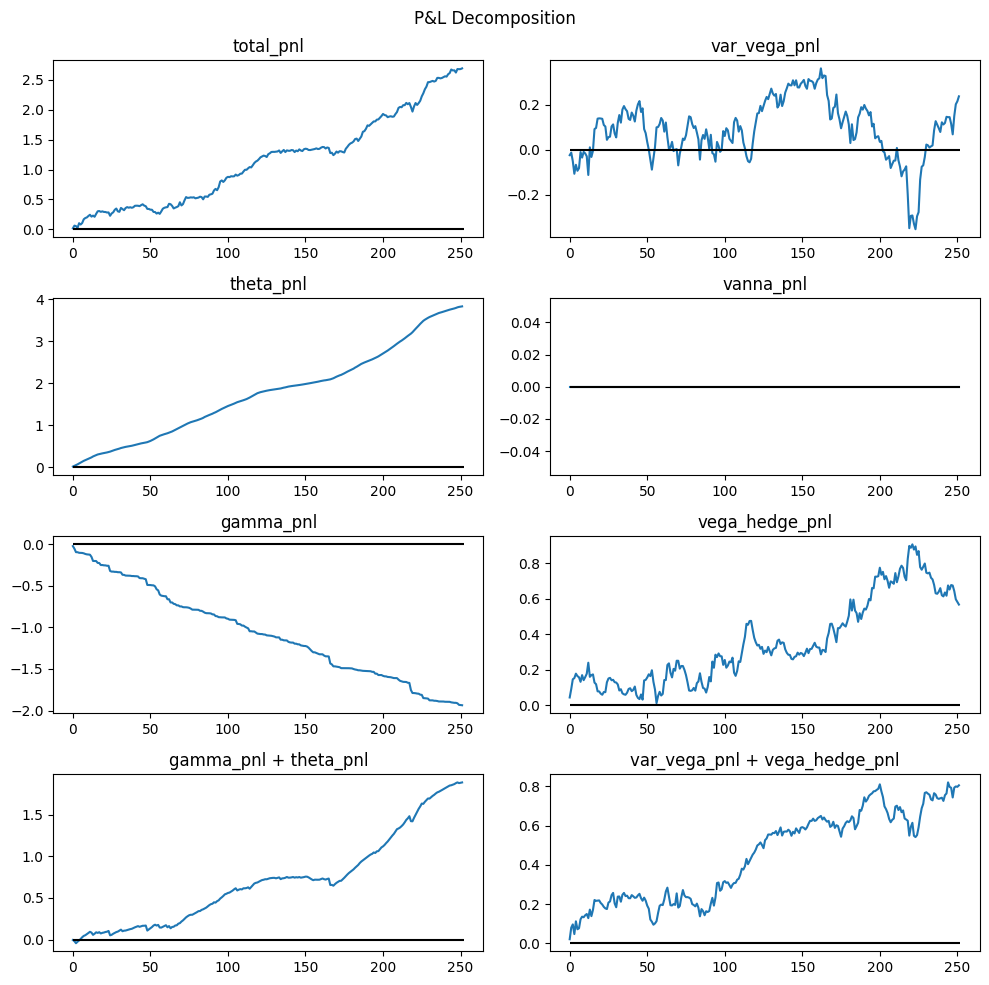

In [7]:
plot_pnl_of_path(cont_short_pnl, 0)

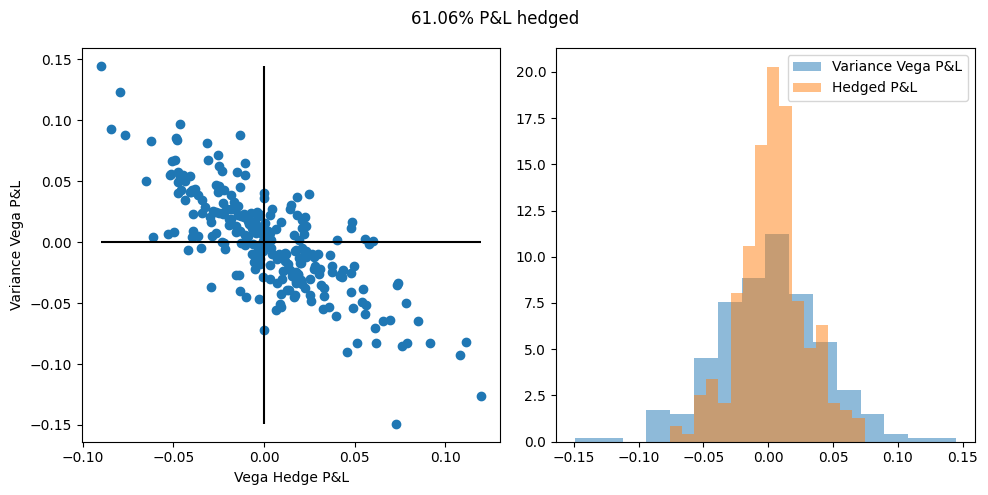

In [8]:
plot_vega_hedge_performance_of_path(cont_short_pnl, 0)

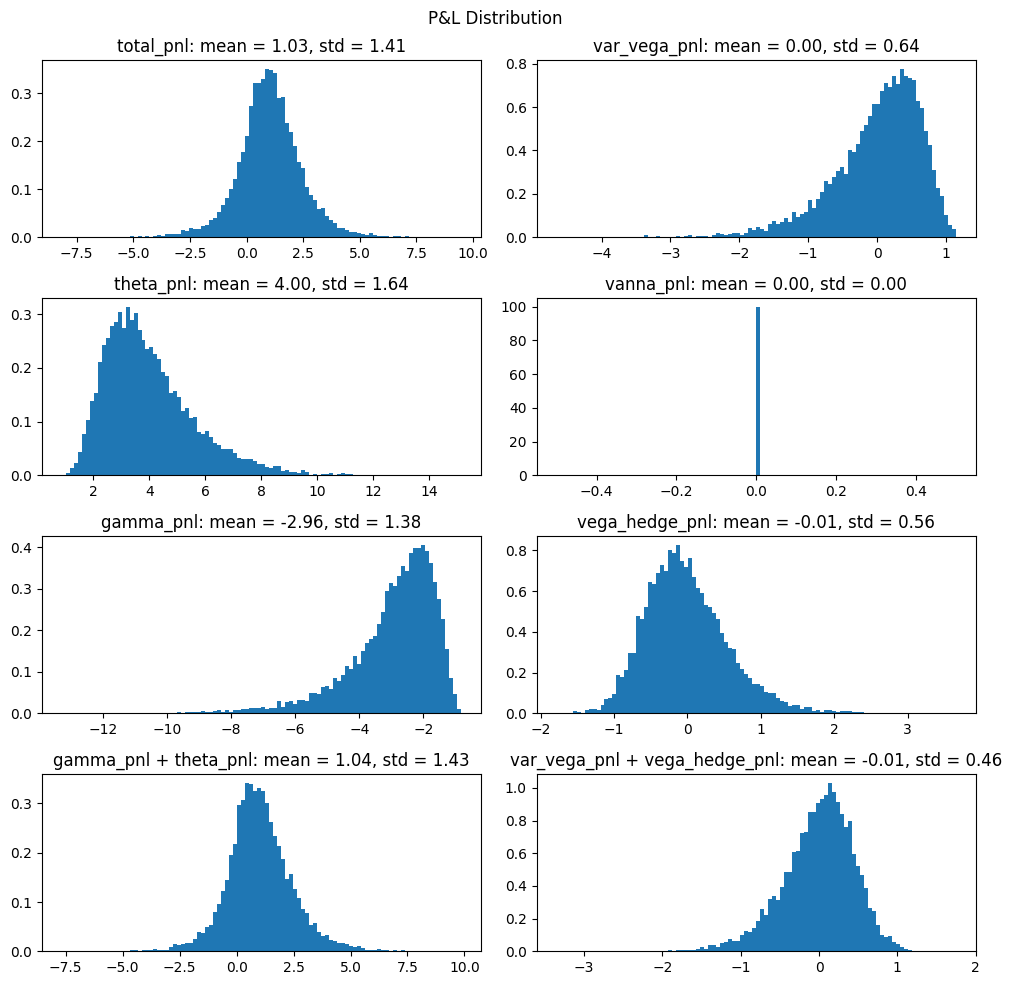

In [9]:
plot_pnl_distribution(cont_short_pnl)

## Volatility Arbitrage Strategy

In [10]:
vol_arb_strategy = 100 * ((real_var[:-1] > imp_var[:-1]).astype(dtype=int) * 2 - 1)
vol_arb_pnl = var_swap_pnl_per_dte[21].get_strategy_pnl(vol_arb_strategy)

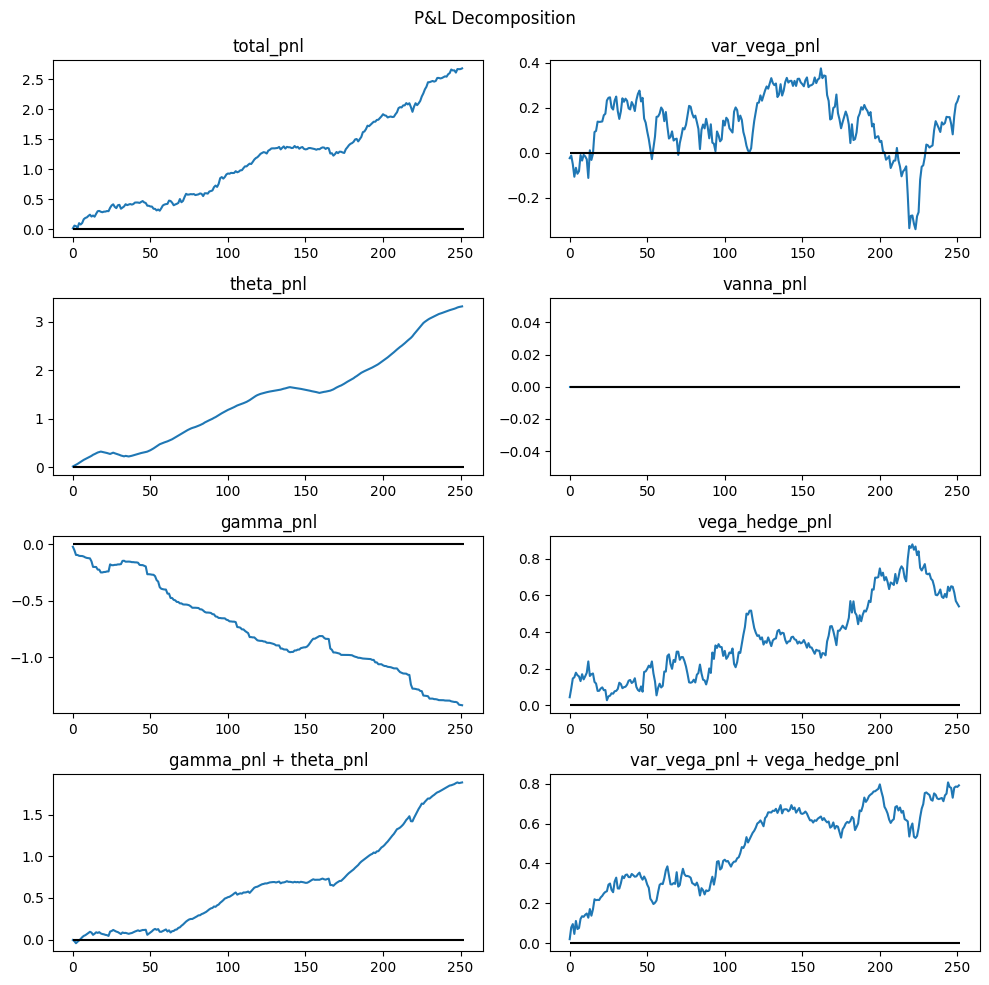

In [11]:
plot_pnl_of_path(vol_arb_pnl, 0)

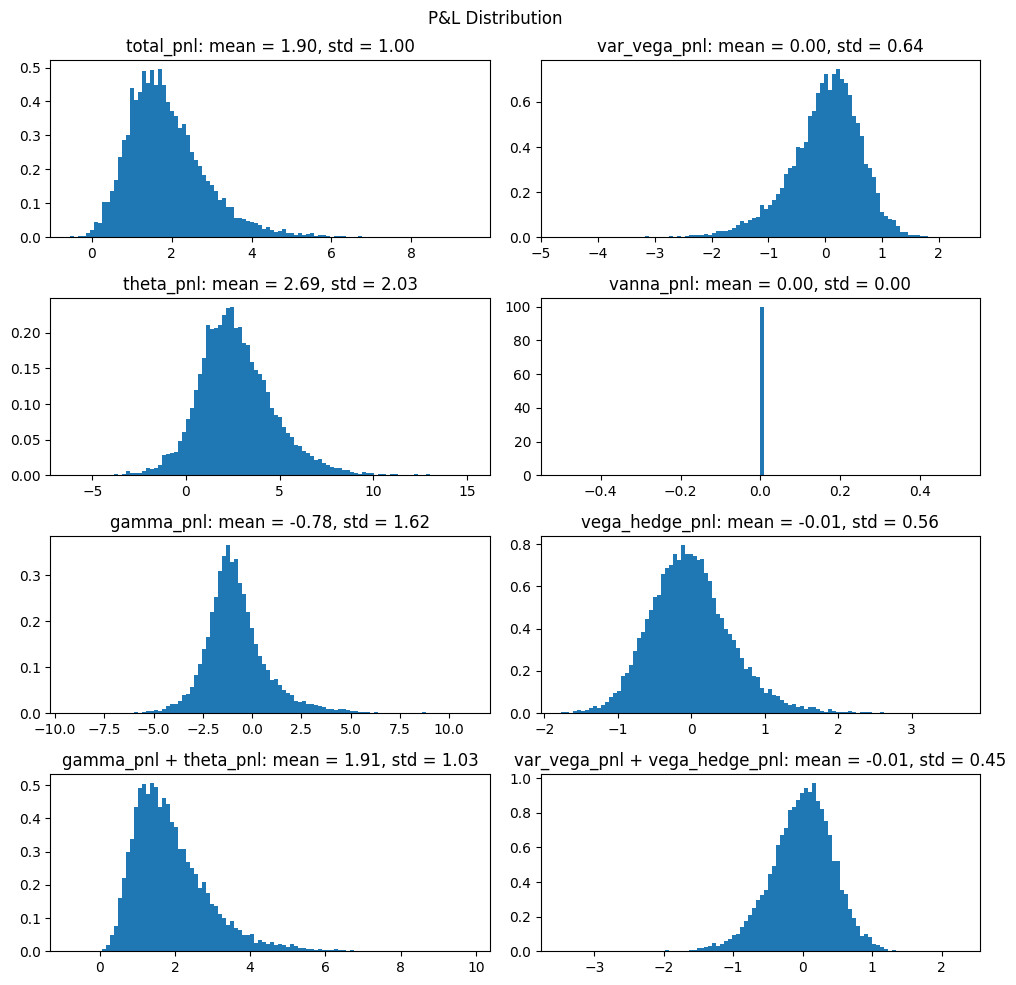

In [12]:
plot_pnl_distribution(vol_arb_pnl)

## Empirical Sharpe Ratio per DTE

In [13]:
ann_sharpe_per_dte: dict[int, npt.NDArray[np.float64]] = {}

for dte, pnl_calculator in var_swap_pnl_per_dte.items():
    vol_arb_pnl = pnl_calculator.get_strategy_pnl(vol_arb_strategy)
    ann_sharpe_per_dte[dte] = vol_arb_pnl["total_pnl"].mean(axis=0) / (
        vol_arb_pnl["total_pnl"].std(axis=0) * np.sqrt(time_delta)
    )

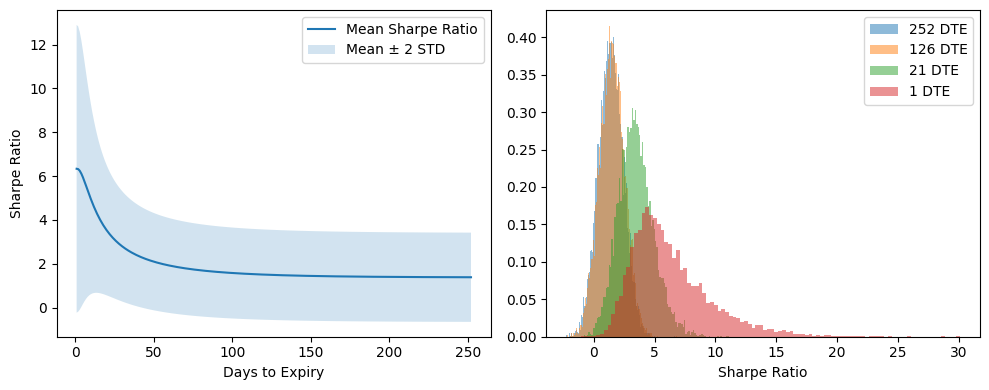

In [19]:
means = [np.mean(ann_sharpe) for ann_sharpe in ann_sharpe_per_dte.values()]
stds = [np.std(ann_sharpe) for ann_sharpe in ann_sharpe_per_dte.values()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(target_dte, means, label="Mean Sharpe Ratio")
ax[0].fill_between(
    target_dte,
    np.array(means) - 2 * np.array(stds),
    np.array(means) + 2 * np.array(stds),
    alpha=0.2,
    label="Mean ± 2 STD",
)
ax[0].set_xlabel("Days to Expiry")
ax[0].set_ylabel("Sharpe Ratio")
ax[0].legend()

for dte in [BDAYS, 21 * 6, 21, 1]:
    ax[1].hist(
        ann_sharpe_per_dte[dte],
        density=True,
        bins=int(np.sqrt(len(ann_sharpe_per_dte[dte]))),
        label=f"{dte} DTE",
        alpha=0.5,
    )
ax[1].set_xlabel("Sharpe Ratio")
ax[1].legend()

fig.tight_layout()
plt.show()